In [2]:
import numpy as np
from scipy.stats import wishart

In [3]:
#initialisation:
mu_beta = np.array([0,0])
sigmasq_y = 1
beta=np.array([[100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [100, 100],
                 [6, 6],
                 [6, 6],
                 [6, 6],
                 [6, 6],
                 [6, 6],
                 [6, 6],
                 [6, 6],
                 [6, 6],
                 [6, 6],
                 [6, 6]])

Sigma_beta = np.array([[1, 0],
                       [0, 1]])

In [6]:
#data:
N=30
T=5
y=np.array([[151, 145, 147, 155, 135],
                 [159, 141, 159, 177, 134],
                 [160, 143, 154, 171, 163],
                 [160, 142, 156, 157, 152],
                 [154, 139, 146, 157, 132],
                 [160, 169, 157, 137, 153],
                 [199, 199, 214, 200, 188],
                 [210, 189, 201, 236, 182],
                 [208, 188, 200, 221, 216],
                 [207, 187, 203, 212, 203],
                 [205, 190, 191, 211, 185],
                 [207, 216, 205, 180, 200],
                 [246, 249, 263, 237, 230],
                 [252, 231, 248, 285, 220],
                 [261, 220, 244, 270, 242],
                 [248, 234, 243, 259, 246],
                 [253, 225, 229, 250, 237],
                 [257, 261, 248, 219, 244],
                 [283, 293, 312, 272, 280],
                 [298, 275, 297, 350, 260],
                 [313, 273, 289, 326, 281],
                 [288, 280, 283, 307, 286],
                 [298, 267, 272, 285, 286],
                 [303, 295, 289, 258, 286],
                 [320, 354, 328, 297, 323],
                 [331, 305, 338, 376, 296],
                 [352, 314, 325, 358, 312],
                 [324, 316, 317, 336, 321],
                 [334, 302, 302, 323, 331],
                 [345, 333, 316, 291, 324]])
x= np.array([8.0, 15.0, 22.0, 29.0, 36.0])
xbar = 22
Omega=np.array([[0.005, 0], [0,5]])

In [7]:
def Gibbs(N,T,x,y,Omega,nchain,init,R,beta,mu0,sigma0):
    chain=np.zeros((nchain+1,3))        # mu_beta1,mu_beta2 et sigma
    latent1=np.zeros((nchain + 1, N))   #beta 1
    latent2=np.zeros((nchain + 1, N))   # beta2
    latent3=[]                          # Omega
    
    latent1[0]=beta[:,0]
    latent2[0]=beta[:,1]
    latent3.append(Omega)
    chain[0]=init
    
    
    for i in range(1,nchain+1):
        beta1=latent1[i-1]  # de taille N
        beta2=latent2[i-1]
        Omega=latent3[i-1]
        mu_beta1=chain[i-1,0]   #mu_beta1
        mu_beta2=chain[i-1,1]   #mu_beta2
        sigma=chain[i-1,2]          # sigma=1/sqrt(tauc)
        
        #update sigma:
        shape_cond=0.001+T*N/2
        mu_col=[beta1+beta2*x[j] for j in range(T)]
        mu=np.column_stack(mu_col)
        rate_cond=0.001+0.5*np.sum((y-mu)**2)
        tauc=np.random.gamma(shape=shape_cond,scale=1/rate_cond)
        sigma=1/np.sqrt(tauc)
        
        #update beta1:
        for k in range(N):
            mean1_cond=(mu_beta1-tauc*Omega[0,0]*(beta2[k]*np.sum(x)-np.sum(y[k])))/(1+tauc*Omega[0,0]*T)
            var1_cond=Omega[0,0]/(1+tauc*Omega[0,0]*T)
            beta1[k]=np.random.normal(mean1_cond,np.sqrt(var1_cond))
            
        #update beta2:
        for k in range(N):
            mean2_cond=(mu_beta2-tauc*Omega[1,1]*(beta1[k]*np.sum(x)-np.sum(y[k])))/(1+tauc*Omega[1,1]*np.sum(x**2))
            var2_cond=Omega[1,1]/(1+tauc*Omega[1,1]*np.sum(x**2))
            beta2[k]=np.random.normal(mean2_cond,np.sqrt(var2_cond))
            
        beta=np.column_stack((beta1, beta2))
        
        #update Omega:
        df=N+2
        mean_beta=np.column_stack((np.full(N, mu_beta1), np.full(N, mu_beta2)))
        S=np.zeros((2,2))
        for k in range(N):
            S=S+np.dot((beta[k]-mean_beta[k]).T,(beta[k]-mean_beta[k]))
        scale=np.linalg.inv(np.linalg.inv(R)+S)
        Omega=wishart.rvs(df, scale)
        
        #update mu_beta1
        mean_mu_beta1=(mu0[0]*Omega[0,0]+sigma0[0,0]**2*np.sum(beta1))/(Omega[0,0]+N*sigma0[0,0]**2)
        var_mu_beta1=sigma0[0,0]**2*Omega[0,0]/(Omega[0,0]+N*sigma0[0,0]**2)
        mu_beta1=np.random.normal(mean_mu_beta1,np.sqrt(var_mu_beta1))
        
        #update mu_beta2
        mean_mu_beta2=(mu0[1]*Omega[1,1]+sigma0[1,1]**2*np.sum(beta2))/(Omega[1,1]+N*sigma0[1,1]**2)
        var_mu_beta2=sigma0[1,1]**2*Omega[1,1]/(Omega[1,1]+N*sigma0[1,1]**2)
        mu_beta2=np.random.normal(mean_mu_beta2,np.sqrt(var_mu_beta2))
        
        ## Store new states
        chain[i]=[mu_beta1,mu_beta2,sigma]
        latent1[i]=beta1
        latent2[i]=beta2
        latent3.append(Omega)
        
    return chain, latent1, latent2,latent3     

In [8]:
nchain=10000
init=[0,0,1]
mu0=np.array([0,0])
sigma0=np.eye(2)
R=np.array([[200,0],[0,0.2]])
chain,latent1,latent2,latent3 =Gibbs(N,T,x,y,Omega,nchain,init,R,beta,mu0,sigma0)
burnin=1000
chain = chain[burnin:]
latent1 = latent1[burnin:]
latent2 = latent2[burnin:]
latent3 = latent3[burnin:]
mu_beta1=chain[:,0]
sig=chain[:,2]

In [9]:
import matplotlib.pyplot as plt

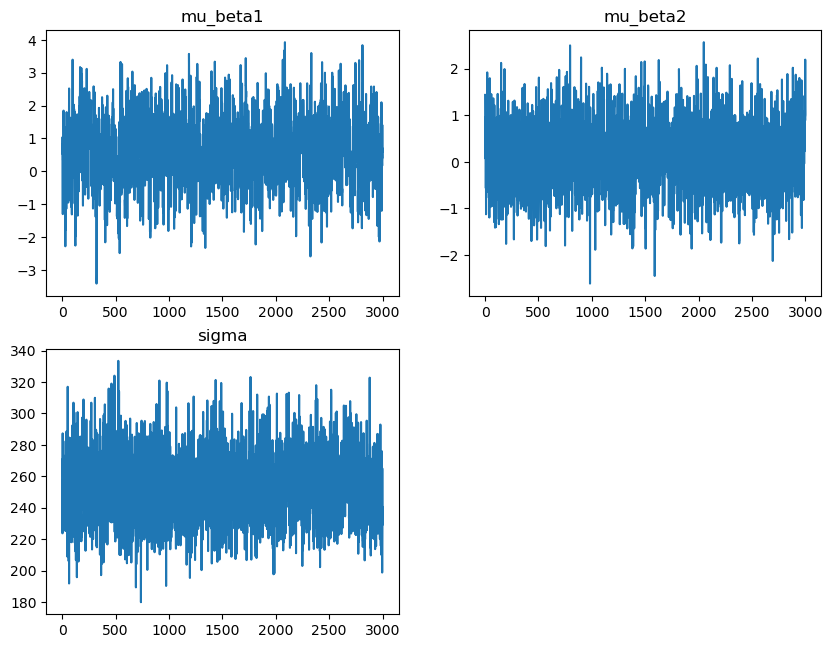

In [10]:
plt.figure(figsize=(10, 20))
param=['mu_beta1','mu_beta2','sigma']
for i in range(3):
    plt.subplot(5,2,i+1)
    plt.plot(chain[::3, i]);
    plt.title(param[i])

In [14]:
mu_beta1=chain[::3, 0]
mu_beta2=chain[::3, 1]
sigma=chain[::3, 2]
mean=[chain[::3, i].mean() for i in range(3)]
var=[chain[::3, i].var() for i in range(3)]

In [ ]:
# resultats incompatibles avec ceux du pdf!!!!!